# Applying classification

- **Hypothesis**
  - The 16s rRNA sequences of prokaryotic phyla are sufficiently distinct that you can determine what phylum a given sequence belongs to without sequence alignment 
- Nearly all taxonomic classification methods for DNA sequences involve operations on the sequences as strings, such as in alignment or k-mer extraction (the latter method being the one used by the sklearn Bayes classifier I used to get the classifications in the first place)
- In this assignment, I wanted to test whether or not using easily-calculated intrinsic properties of DNA sequences, like base composition and GC-ratio would be sufficient to distinguish between different groups of prokaryotes. I'll first test the classifier at the phylum level (the second most highest taxonomic rank). 
    - Of course, this wouldn't be practical as an actual classification method, but it would be interesting to see whether or not these features are different enough between phyla for the classifier to work

In [207]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from qiime2 import Artifact
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, roc_auc_score
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn import metrics
seqs = pd.DataFrame(Artifact.load("./results/2-OTUs/Merged-otuSeqs.qza").view(pd.Series).rename("Feature ID"))
ids = pd.DataFrame(Artifact.load("./results/3-Classified/Merged-Sklearn.qza").view(pd.DataFrame)["Taxon"])

In [152]:
def num_pu_runs(sequence):
    gen = sequence.find_motifs("purine-run")
    return(len(list(gen)))

def num_py_runs(sequence):
    gen = sequence.find_motifs("pyrimidine-run")
    return(len(list(gen)))

def get_rank(taxonomy, level):
    ranks = taxonomy.split(";")
    if len(ranks) < level:
        return pd.NA
    return ranks[level - 1].strip()

def get_features(seqs, rank_str, rank_int):
    features: dict = { "n_purine_runs": [], "n_pyrimidine_runs": [],
        "gc_content": [], rank_str: [], "relA": [], "relG": [], "relT": []}
    for r in merged.iterrows():
        taxonomy = r[1][1] 
        seq = r[1][0] 
        if len(seq) > 99:
            cut_to = round((len(seq) - 99)/2)
            seq = seq[cut_to:-cut_to] # Slice the sequences to at most 99 bases
        features[rank_str].append(get_rank(taxonomy, rank_int))
        features["gc_content"].append(seq.gc_content())
        features["n_pyrimidine_runs"].append(num_py_runs(seq))
        features["n_purine_runs"].append(num_pu_runs(seq))
        base_freqs = seq.frequencies(relative = True)
        features["relA"].append(base_freqs.get("A", 0))
        features["relG"].append(base_freqs.get("G", 0))
        features["relT"].append(base_freqs.get("T", 0))
    features = pd.DataFrame(features).dropna()
    return features

merged = pd.merge(seqs, ids, left_index = True, right_on = "Feature ID")

The selected features are those available from the skbio DNA sequence object (which is what the OTU sequences get imported as from the qiime2 artifact).
- They include base composition, the number of purine and pyrimidine runs (repeats of either) and the GC content

## Principle components analysis on features

<Figure size 640x480 with 0 Axes>

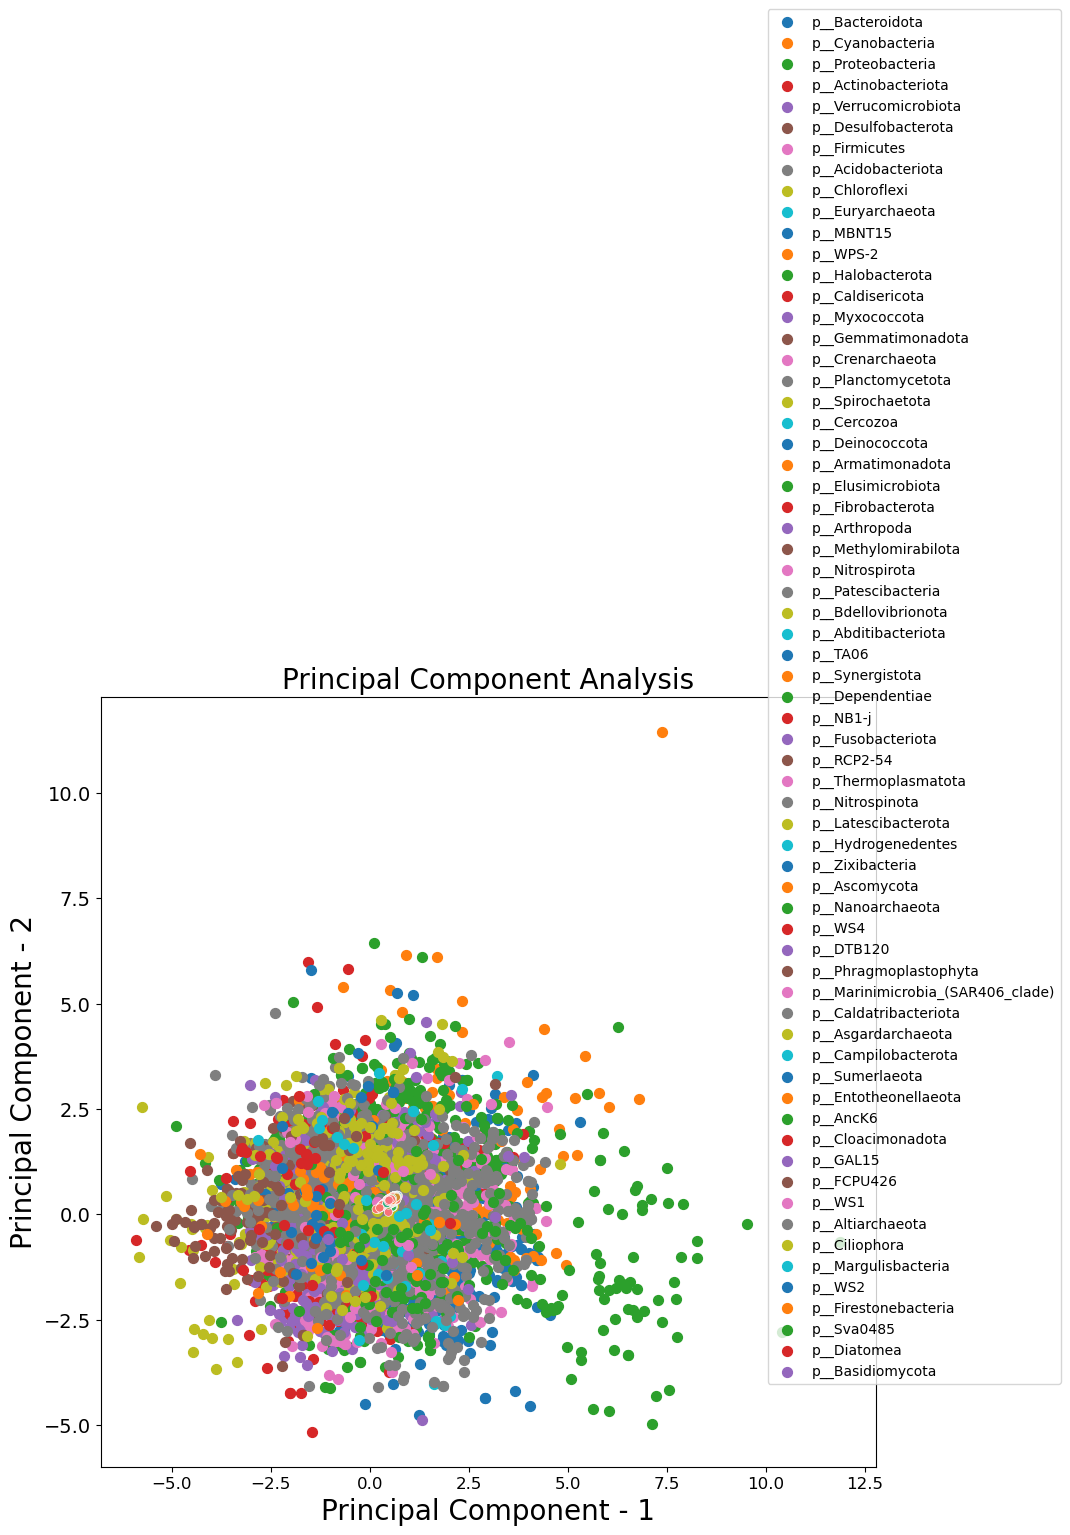

In [268]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import numpy as np
to_pca = phyla_features.drop("phylum", axis = 1)
x_standard = StandardScaler().fit_transform(to_pca)
feat_cols = ['feature'+str(i) for i in range(x_standard.shape[1])]
normalized = pd.DataFrame(x_standard, columns=feat_cols)
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(normalized)
pc_df = pd.DataFrame(data = principalComponents, columns = ["PC1", "PC2"])
test = np.array(phyla_features["phylum"] == "p__Proteobacteria")
plt.figure()
plt.figure(figsize=(10,10))
plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
plt.xlabel('Principal Component - 1',fontsize=20)
plt.ylabel('Principal Component - 2',fontsize=20)
plt.title("Principal Component Analysis",fontsize=20)
targets = phyla_features["phylum"].unique()
for target in targets:
    indicesToKeep = np.array(phyla_features['phylum'] == target)
    plt.scatter(pc_df.loc[indicesToKeep, 'PC1'],
            pc_df.loc[indicesToKeep, 'PC2'], s = 50)
sns.scatterplot(data = phyla_features, x = phyla_features["gc_content"], 
    y = phyla_features["relG"], hue = phyla_features["phylum"], legend = False)
plt.legend(targets, bbox_to_anchor=(1.05, 1), loc = 10)

It's a real mess, indicating that many bacterial phyla overlap in the chosen features, as is to be expected. However, the Proteobacteria (green), are relatively singled out from the rest

## Decision tree model

,n_purine_runs,n_pyrimidine_runs,gc_content,phylum,relA,relG,relT
0,22,23,0.454545,p__Bacteroidota,0.262626,0.313131,0.282828
1,24,24,0.490000,p__Cyanobacteria,0.300000,0.290000,0.210000
2,20,21,0.510000,p__Cyanobacteria,0.310000,0.300000,0.180000
3,25,24,0.510000,p__Proteobacteria,0.250000,0.330000,0.240000
4,26,27,0.535354,p__Proteobacteria,0.252525,0.323232,0.212121
...,...,...,...,...,...,...,...
10639,26,27,0.545455,p__Planctomycetota,0.202020,0.363636,0.252525
10643,25,25,0.474747,p__Cyanobacteria,0.292929,0.303030,0.232323
10651,22,21,0.561224,p__Verrucomicrobiota,0.265306,0.326531,0.173469
10652,23,24,0.540000,p__Proteobacteria,0.260000,0.360000,0.200000


X train shape: (5346, 6)
y train shape: (5346,)
Accuracy: 0.7693602693602694
ROC 0.6525143150785493


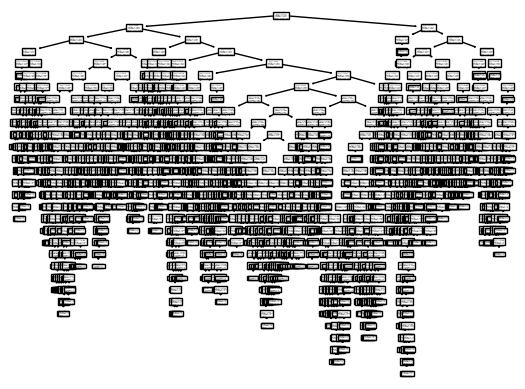

In [237]:
phyla_features = get_features(merged, "phylum", 2)
display(phyla_features)
dummy_phyla = pd.get_dummies(phyla_features["phylum"])
y = dummy_phyla["p__Proteobacteria"]
X = pd.concat([phyla_features.drop("phylum", axis = 1)], axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)
print(f'X train shape: {X_train.shape}')
print(f'y train shape: {y_train.shape}')
dt_model = DecisionTreeClassifier(criterion = "entropy")
dt_model.fit(X_train, y_train)
_ = plot_tree(dt_model) 
prediction = dt_model.predict(X_test)
print(f'Accuracy: {accuracy_score(y_test, prediction)}')
print(f'ROC {roc_auc_score(y_test, prediction)}')

## Random forest model
Can a random forest model do better at the same task?

In [203]:
rf_model = RandomForestClassifier(n_estimators=100)
rf_model.fit(X_train, y_train)
print(f'X train shape: {X_train.shape}')
print(f'y train shape: {y_train.shape}')
rf_pred = rf_model.predict(X_test)
print(f'Accuracy: {accuracy_score(y_test, rf_pred)}')
print(f'ROC: {roc_auc_score(y_test, rf_pred)}')
display(X_train)
importance = pd.Series(rf_model.feature_importances_, index = X_train.columns).sort_values(ascending = False)

X train shape: (5346, 6)
y train shape: (5346,)
Accuracy: 0.8013468013468014
ROC: 0.6528703567758039


,n_purine_runs,n_pyrimidine_runs,gc_content,relA,relG,relT
3801,23,22,0.515152,0.222222,0.363636,0.262626
4648,23,24,0.620000,0.220000,0.360000,0.160000
1767,21,22,0.555556,0.232323,0.343434,0.212121
950,22,23,0.555556,0.232323,0.343434,0.212121
2165,24,23,0.540816,0.204082,0.316327,0.255102
...,...,...,...,...,...,...
6361,29,29,0.418367,0.346939,0.265306,0.234694
4023,23,23,0.595960,0.202020,0.373737,0.202020
1971,22,22,0.530000,0.290000,0.300000,0.180000
3162,24,25,0.575758,0.222222,0.343434,0.202020


relG                 0.242485
gc_content           0.182621
relT                 0.182581
relA                 0.167768
n_purine_runs        0.120319
n_pyrimidine_runs    0.104227
dtype: float64

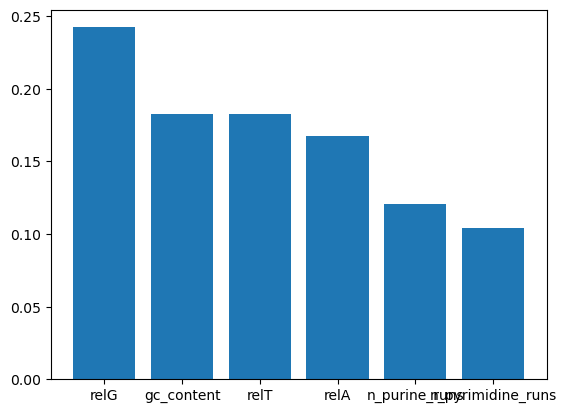

In [205]:
fig, ax = plt.subplots()
ax.bar(x = importance.index, height = importance)
plt.xticks(range(features.shape[1]), names, rotation=90)
plt.show()

# Train to predict Classes
The decision tree classifier seemed reasonably good on predicting whether or not a given sequence was from Proteobacteria based

,n_purine_runs,n_pyrimidine_runs,gc_content,class,relA,relG,relT
0,22,23,0.454545,c__Bacteroidia,0.262626,0.313131,0.282828
1,24,24,0.490000,c__Cyanobacteriia,0.300000,0.290000,0.210000
2,20,21,0.510000,c__Cyanobacteriia,0.310000,0.300000,0.180000
3,25,24,0.510000,c__Gammaproteobacteria,0.250000,0.330000,0.240000
4,26,27,0.535354,c__Gammaproteobacteria,0.252525,0.323232,0.212121
...,...,...,...,...,...,...,...
10633,22,21,0.250000,c__Alphaproteobacteria,0.390000,0.150000,0.360000
10643,25,25,0.474747,c__Cyanobacteriia,0.292929,0.303030,0.232323
10651,22,21,0.561224,c__Chlamydiae,0.265306,0.326531,0.173469
10652,23,24,0.540000,c__Gammaproteobacteria,0.260000,0.360000,0.200000


0.8392070484581498
0.6445685279187816


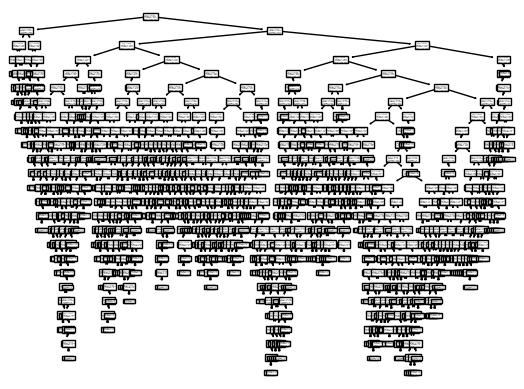

In [171]:
class_features = get_features(merged, "class", 3)
display(class_features)
dummy_classes = pd.get_dummies(class_features["class"])
y = dummy_classes["c__Gammaproteobacteria"]
X = pd.concat([class_features.drop("class", axis = 1)], axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
dt_model = DecisionTreeClassifier(criterion = "entropy")
dt_model.fit(X_train, y_train)
_ = plot_tree(dt_model) 
prediction = dt_model.predict(X_test)
print(accuracy_score(y_test, prediction))
print(roc_auc_score(y_test, prediction))

,n_purine_runs,n_pyrimidine_runs,gc_content,family,relA,relG,relT
0,22,23,0.454545,f__Bacteroidetes_vadinHA17,0.262626,0.313131,0.282828
1,24,24,0.490000,f__Leptolyngbyaceae,0.300000,0.290000,0.210000
2,20,21,0.510000,f__Chloroplast,0.310000,0.300000,0.180000
3,25,24,0.510000,f__Comamonadaceae,0.250000,0.330000,0.240000
4,26,27,0.535354,f__Comamonadaceae,0.252525,0.323232,0.212121
...,...,...,...,...,...,...,...
10627,23,22,0.530000,f__Cytophagaceae,0.240000,0.330000,0.230000
10633,22,21,0.250000,f__Mitochondria,0.390000,0.150000,0.360000
10643,25,25,0.474747,f__Nostocaceae,0.292929,0.303030,0.232323
10652,23,24,0.540000,f__Pasteurellaceae,0.260000,0.360000,0.200000


0.959070796460177
0.6971114453145256


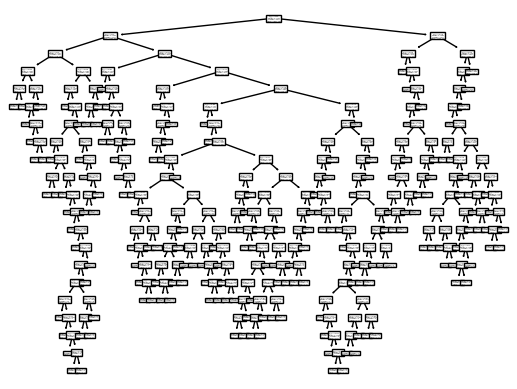

In [177]:
family_features = get_features(merged, "family", 5)
display(family_features)
dummy_families = pd.get_dummies(family_features["family"])
family_features["family"].value_counts()
y = dummy_families["f__Pedosphaeraceae"]
X = family_features.drop("family", axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
dt_model = DecisionTreeClassifier(criterion = "entropy")
dt_model.fit(X_train, y_train)
_ = plot_tree(dt_model) 
prediction = dt_model.predict(X_test)
print(accuracy_score(y_test, prediction))
print(roc_auc_score(y_test, prediction))

The model is probably better at classifying lower taxonomic ranks simply because there are more instances of "no"